In [131]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 


matplotlib.rcParams['figure.figsize'] = (25, 5)

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 10
cfg.obs_dim = 100
cfg.p_factor = 2
cfg.covar_factor = np.eye(cfg.factor_dim)/100
cfg.p_eps = 0
cfg.covar_eps = np.eye(cfg.obs_dim)/1000
cfg.T_train = 4096
cfg.T_test = 2048
cfg.T_val = 512
cfg.T = cfg.T_train + cfg.T_test + cfg.T_val
cfg.use_default_data = True
cfg.saved_index = 2


#Training config
cfg.batch_size = 512
cfg.n_epoch = 100
cfg.max_iter = 15
cfg.n_epoch = 20
cfg.lr = 0.0001

## Nonlinear decoder DGP
Obtain the simulated $y$

Decoder(
  (activation): Tanh()
  (sequential): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): Tanh()
  )
)
(4096, 100) (512, 100) (2048, 100)


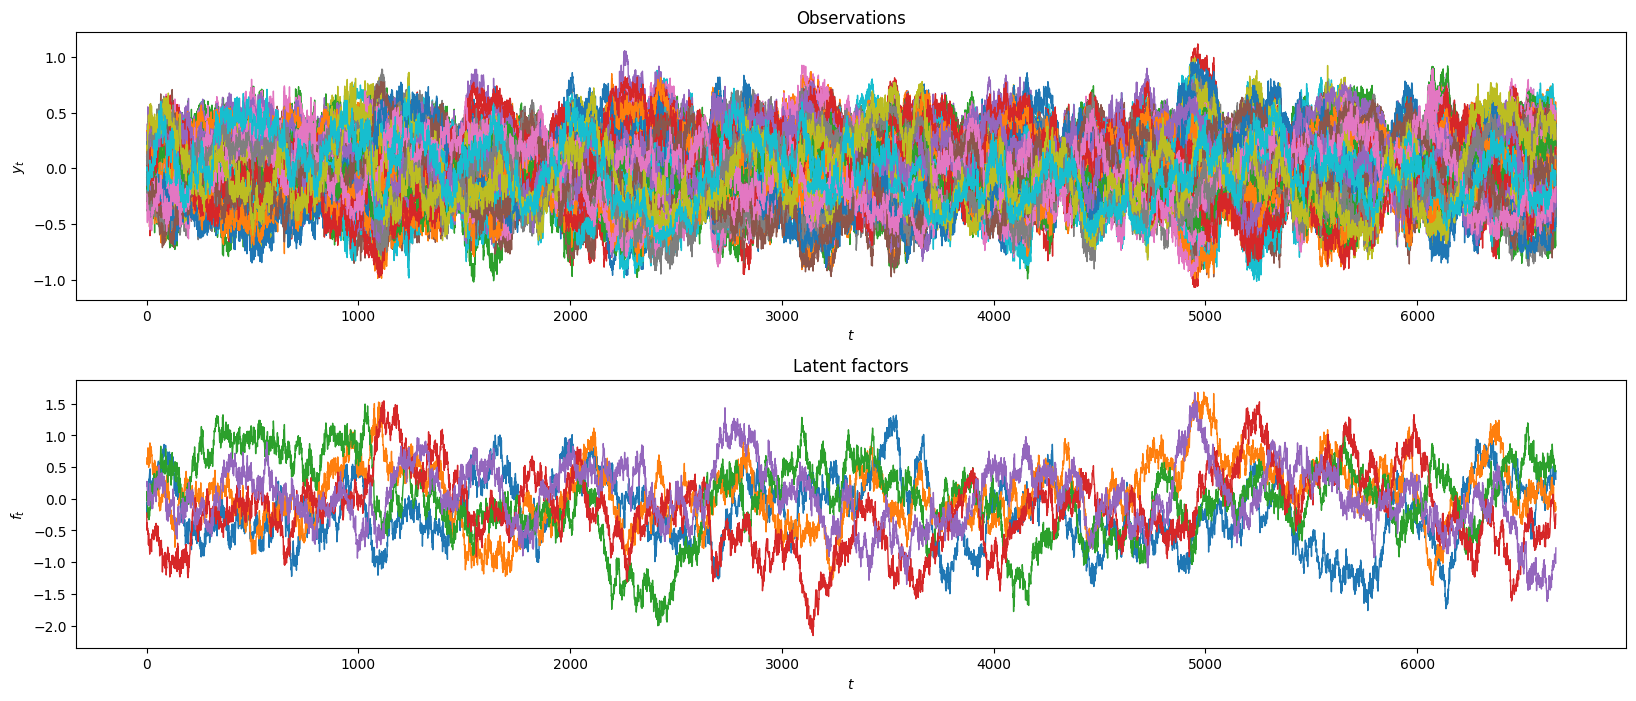

In [133]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim, 20, 40, 80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, use_xavier=False)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

In [136]:
#torch.save(dec, '../DGP/saved/dec_2.pt')
#np.save(arr=y, file='../DGP/saved/y_2.npy')
#np.save(arr=f, file='../DGP/saved/f_2.npy')

## Estimate nonlinear model
TODO: this should all be hyperparameter tuned etc.

In [112]:
dec = Decoder(hidden_dim=[cfg.factor_dim, 50, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False)
enc = Encoder(hidden_dim=[cfg.obs_dim, 50, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
metrics = [CCACorr(f_train=f_train, f_val=f_val)]

train_hist = trainMCMC(X_train=y_train, X_val = y_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter = cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")
nonlinear_train_hist = train_hist #save for comparison later on

/Users/julianvanmeggelen/Documents/Studie/2022:23/Thesis/Simulation/../BasicAutoEncoder/model.py:54: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


Number of trainable paramaters 10705
torch.Size([4096, 100]) torch.Size([512, 100])
1 1.0678251683712006683712006
2 0.10277495719492435719492435
3 0.06096969638019869638019884
4 0.038732119370251894370251894
5 0.026926056481897836481897837
6 0.017171390703879297703879297
7 0.011463997419923544419923544
8 0.008390156901441514901441514
9 0.0069417268387041998387041995
10 0.006169934058561921585619214
11 0.005725772934965789349657895
12 0.00530571112176403421764034
13 0.004966576932929456329294565
14 0.004734385584015399840153995
15 0.00455561280250549302505493
16 0.00433681486174464261744642
Training loss: 0.004336814861744642, Validation Loss: 0.002662121318280697


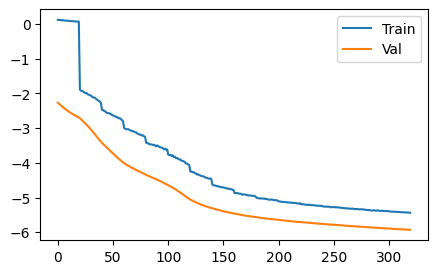

In [113]:
plot_train_hist(train_hist, log=True)

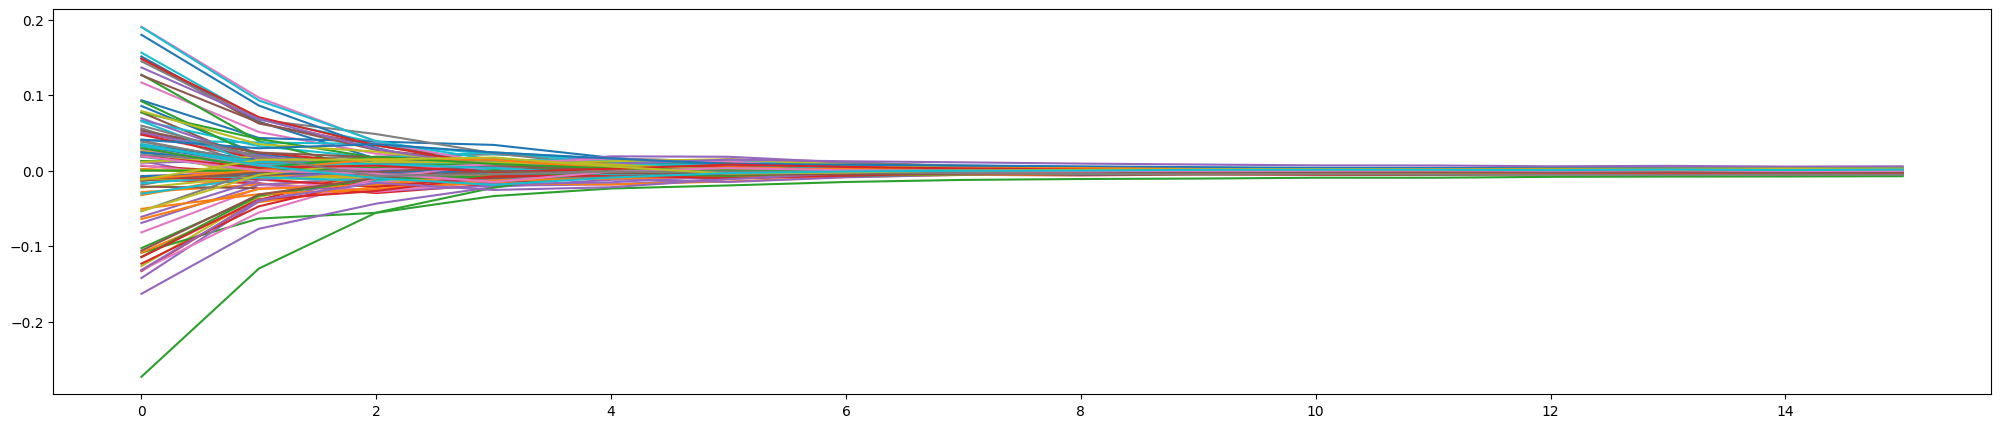

In [114]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

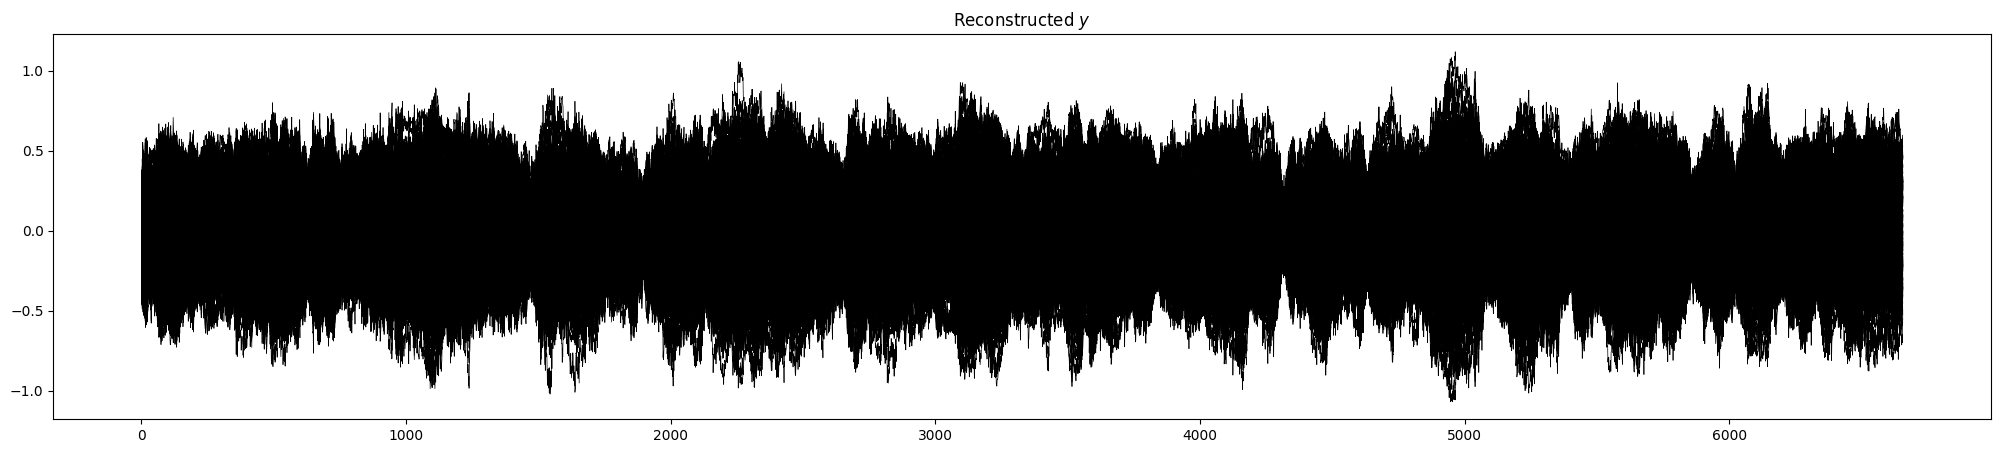

In [115]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


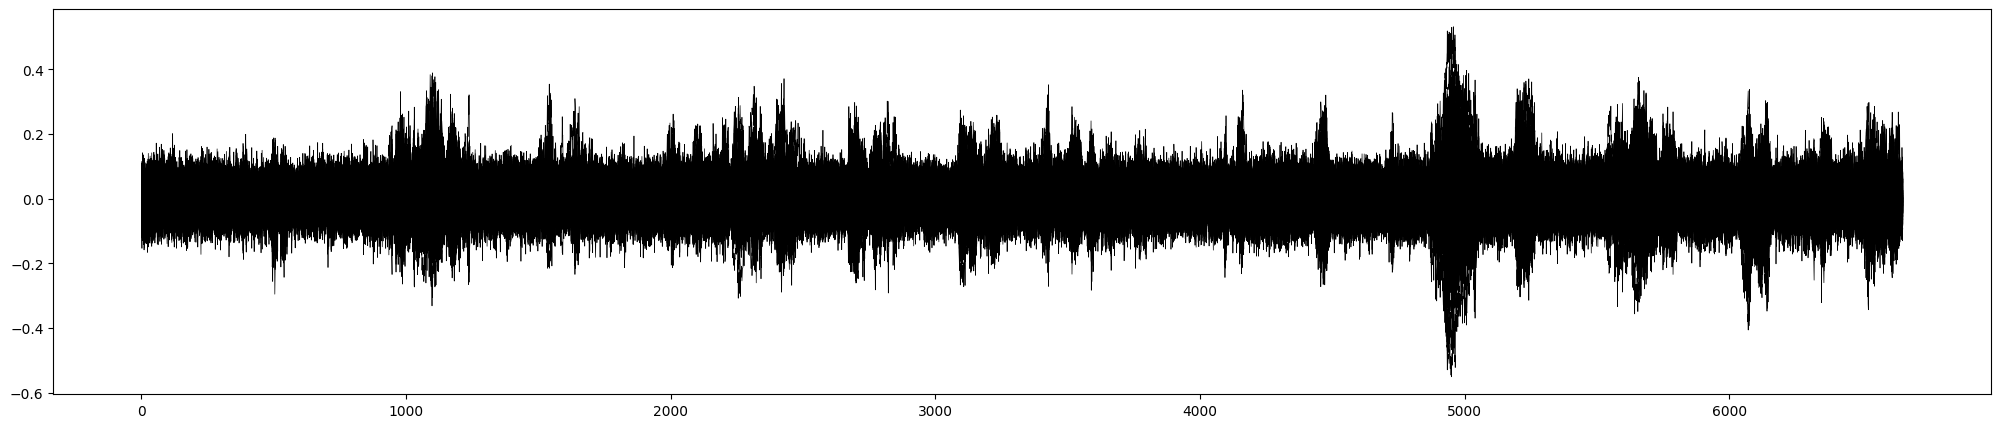

In [116]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

Text(0, 0.5, 'Mean cann. corr.')

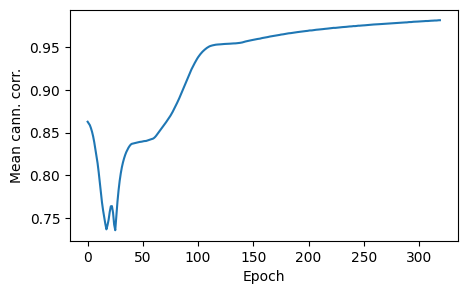

In [117]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['val_CCA_mean_corr'])

plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')

In [118]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

cc on train data: 0.9914524170568499
cc on test data: 0.9835310196840318
cc on train data:  0.9914522478916222
cc on test data:  0.9835308732706547


/Users/julianvanmeggelen/Library/Python/3.9/lib/python/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


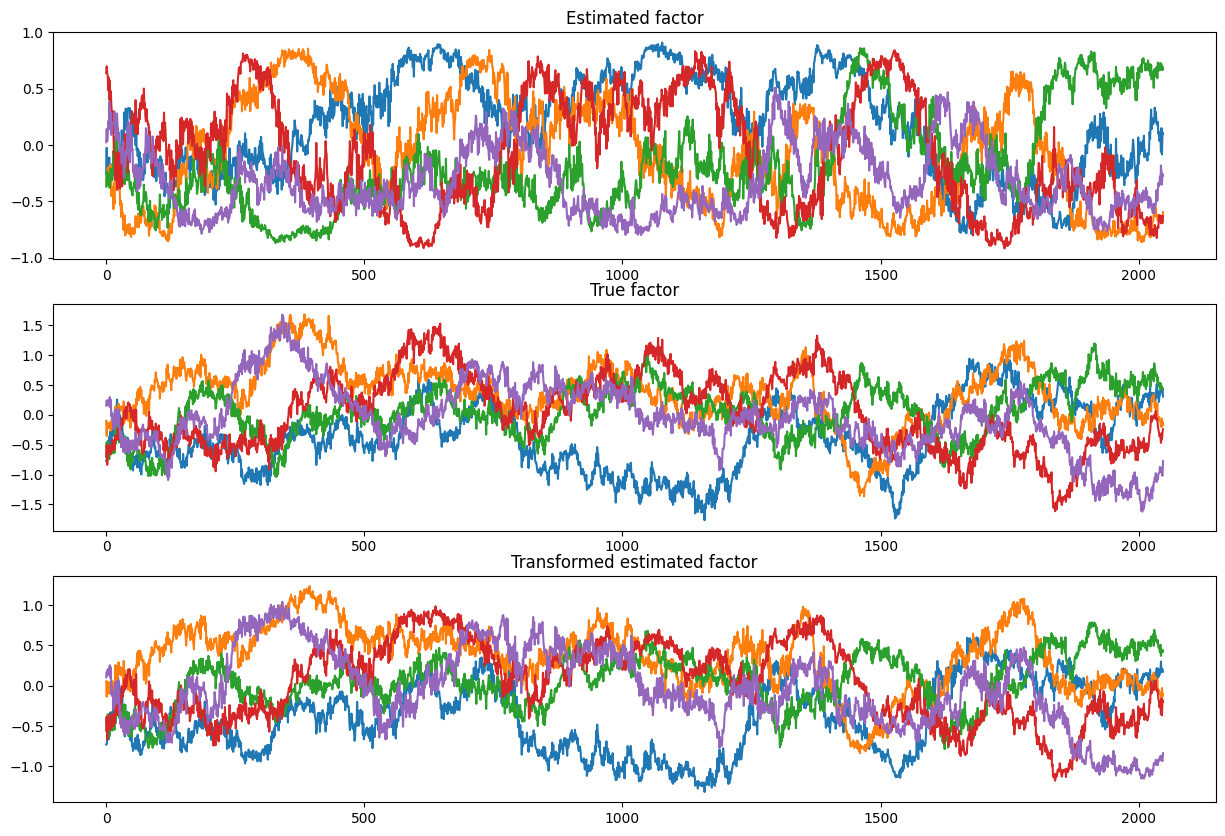

In [119]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

1-step ahead  FMSE on the test set: 0.006709529552608728


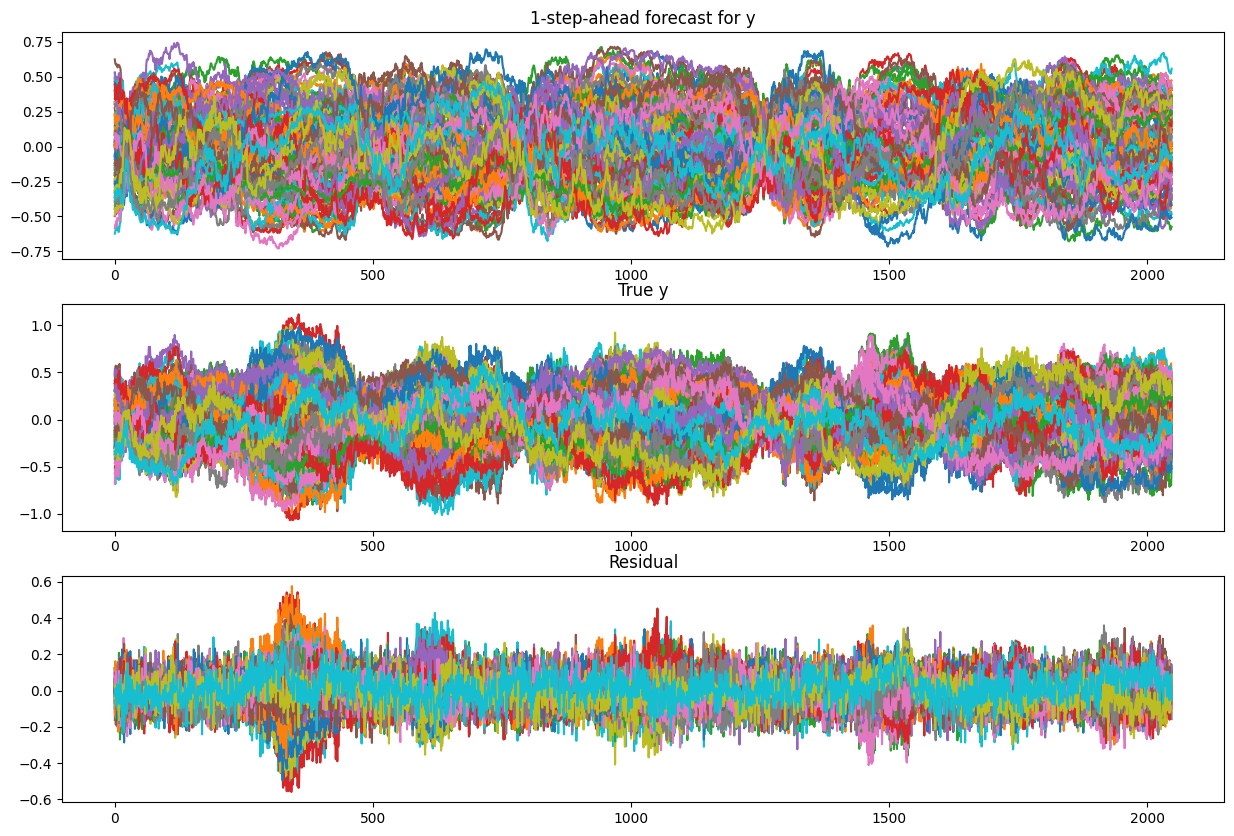

In [120]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")

## Estimate linear model on nonlinear DGP

In [121]:
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Identity())
enc = Encoder(hidden_dim=[cfg.obs_dim, cfg.factor_dim], activation=nn.Identity())
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
metrics = [CCACorr(f_train=f_train, f_val=f_val)]
train_hist = trainMCMC(X_train=y_train, X_val = y_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter=cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")
linear_train_hist = train_hist

/Users/julianvanmeggelen/Documents/Studie/2022:23/Thesis/Simulation/../BasicAutoEncoder/model.py:54: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


Number of trainable paramaters 1105
torch.Size([4096, 100]) torch.Size([512, 100])
1 1.6461922675371172675371172
2 0.26422315463423735463423735
3 0.21505787409842014409842014
4 0.19455721601843834601843834
5 0.18764535710215569710215569
6 0.17879017256200314256200314
7 0.17403855547308922547308922
8 0.16768891364336014364336014
9 0.16232192702591422702591423
10 0.1593034416437149164371492
11 0.1505849640816456408164557
12 0.1466884128749370687493706
13 0.1397825907915830679158306
14 0.1338129639625549396255493
15 0.1260446608066558880665588
16 0.1207363912835717228357172
Training loss: 0.12073639128357172, Validation Loss: 0.05947726219892502


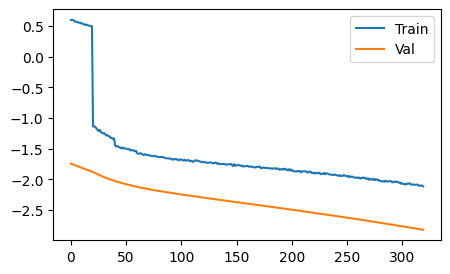

In [122]:
plot_train_hist(train_hist, log=True)

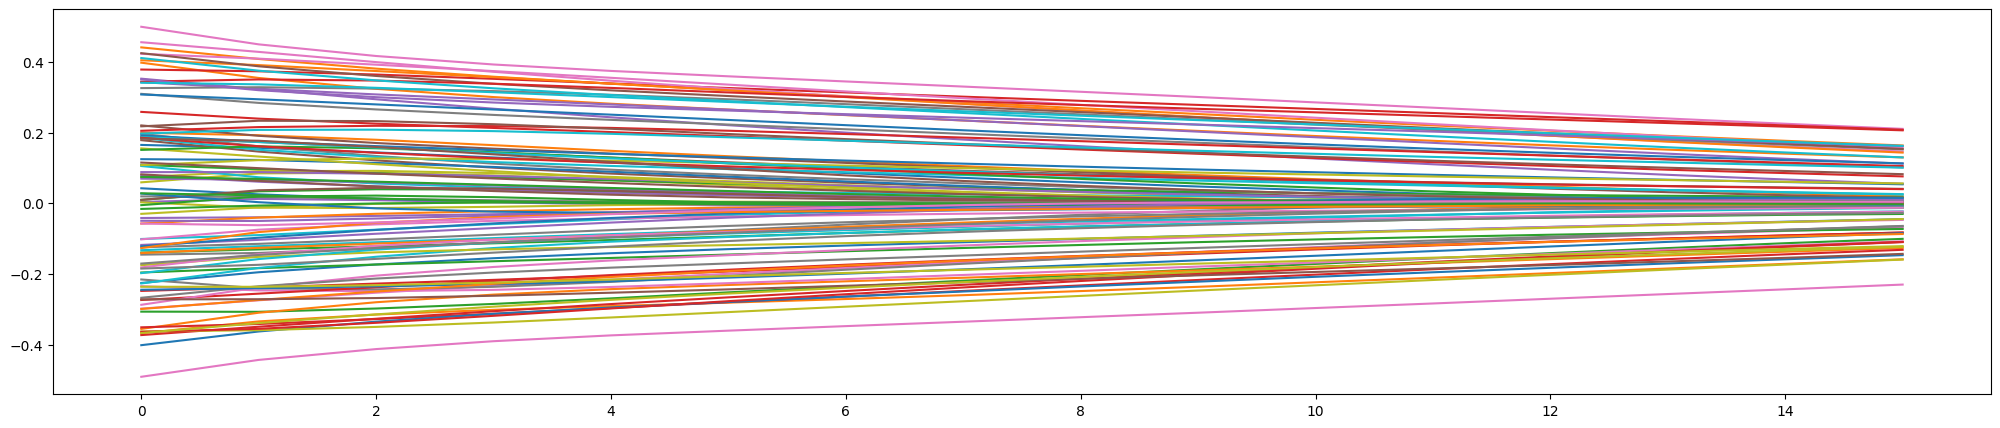

In [123]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

In [124]:
#plt.plot(np.stack(errorProcess.fit_hist['coeff'])[:,:,4]);

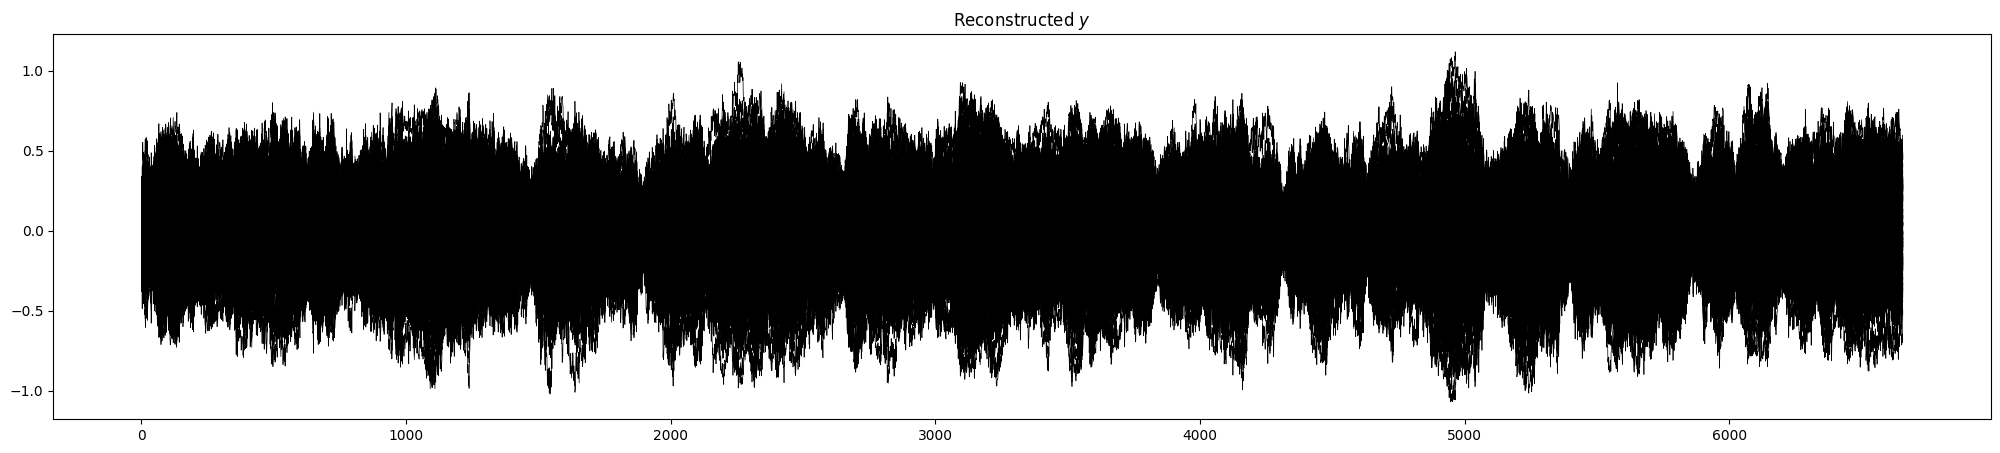

In [125]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


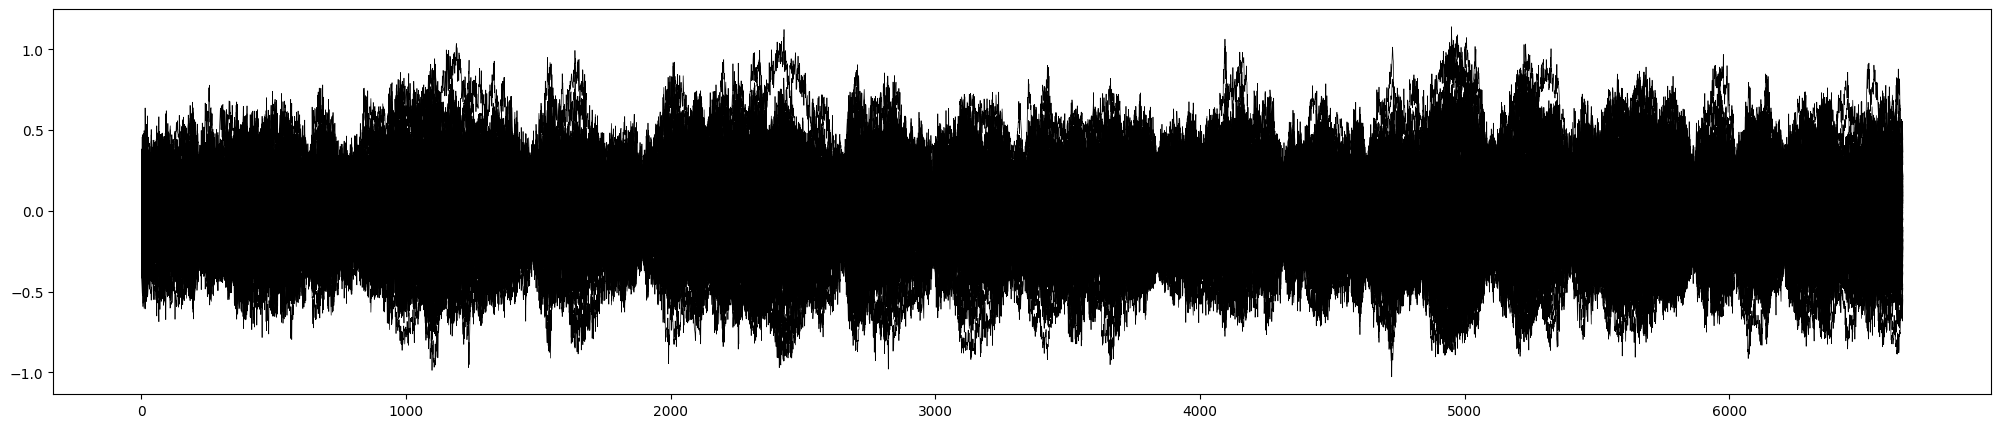

In [126]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

Text(0, 0.5, 'Mean cann. corr.')

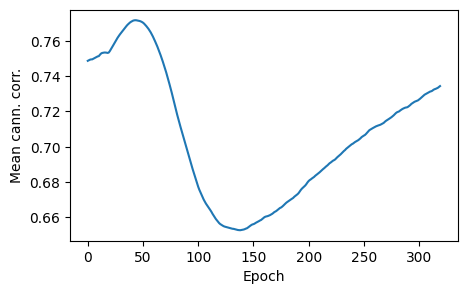

In [127]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['val_CCA_mean_corr'])

plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')

In [128]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

cn_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

# calculate and plot the correlations of all components
print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

cn_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

# calculate and plot the correlations of all components
print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

cc on train data: 0.7743858019645693
cc on test data: 0.7327753322376274
cc on train data:  0.77438575896372
cc on test data:  0.7327752954311156


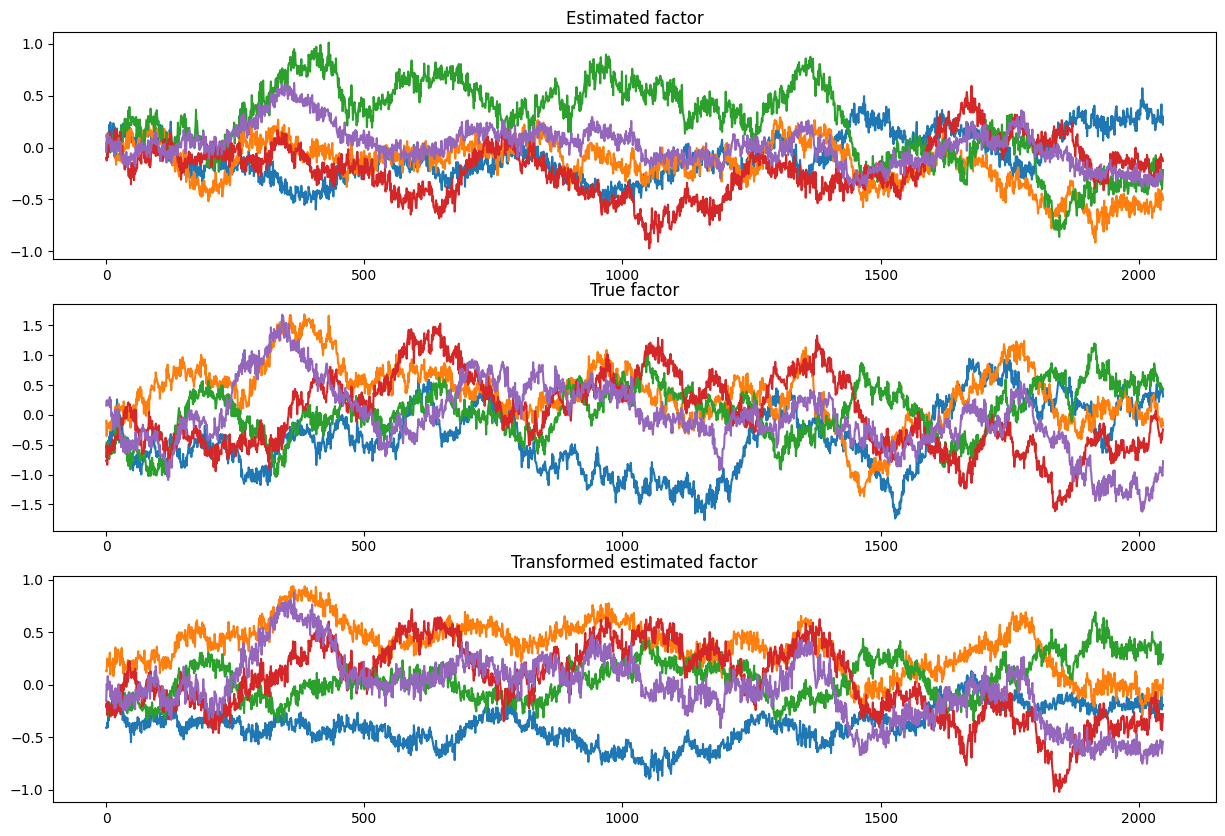

In [129]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

Selected 9 lags
1-step ahead  FMSE on the test set: 0.0788675993680954


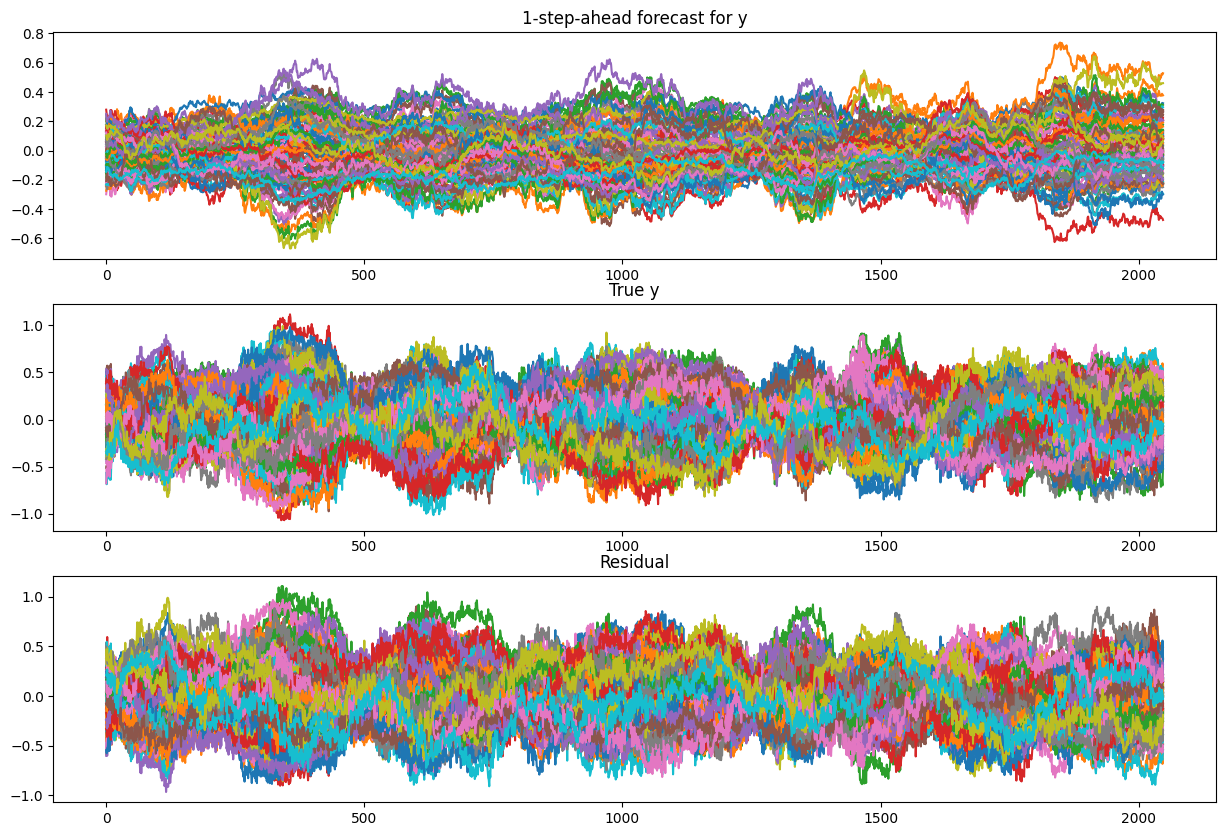

In [130]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
print(f"Selected {res.k_ar} lags")
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")